In [18]:
using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using StatsBase, JLD

### Approximate SyncRank with sparsified Laplacian 


MUN graph model

least eigval of Laplacian= 0.010952482451912535
method: 

DPP(K) unif
least eigenvalue of sparsifier: 0.0003832452365544987
least eigenvalue of sparsifier: 

0.006094156732809465


least eigenvalue of sparsifier: 0.007074258276168765
least eigenvalue of sparsifier: 

0.0084867670404235


least eigenvalue of sparsifier: 0.0087471796391797
least eigenvalue of sparsifier: 

0.010536703364406411


least eigenvalue of sparsifier: 0.010235002279548114
method: 

DPP(K) JL-LS
least eigenvalue of sparsifier: 0.0002991621535899224
least eigenvalue of sparsifier: 

0.00617145599437784


least eigenvalue of sparsifier: 0.007180791578148342
least eigenvalue of sparsifier: 

0.008836765414751379


least eigenvalue of sparsifier: 0.009863143742329767
least eigenvalue of sparsifier: 

0.008806157850997342


least eigenvalue of sparsifier: 0.008247615658184309
method: 

DPP(K) LS
least eigenvalue of sparsifier: 0.0001629386010795152
least eigenvalue of sparsifier: 

0.0065240784077817155


least eigenvalue of sparsifier: 0.008277603797765563
least eigenvalue of sparsifier: 

0.007567184917738056


least eigenvalue of sparsifier: 0.009537441605598204
least eigenvalue of sparsifier: 

0.008488015475792043


least eigenvalue of sparsifier: 0.008852369652729751
method: 

iid JL-LS
least eigenvalue of sparsifier: 0.00019779510879326299
least eigenvalue of sparsifier: 

0.0022077965473262483


least eigenvalue of sparsifier: 0.007010423531910085
least eigenvalue of sparsifier: 

0.00791128346650131


least eigenvalue of sparsifier: 0.00920598734817981
least eigenvalue of sparsifier: 

0.009588925449880482


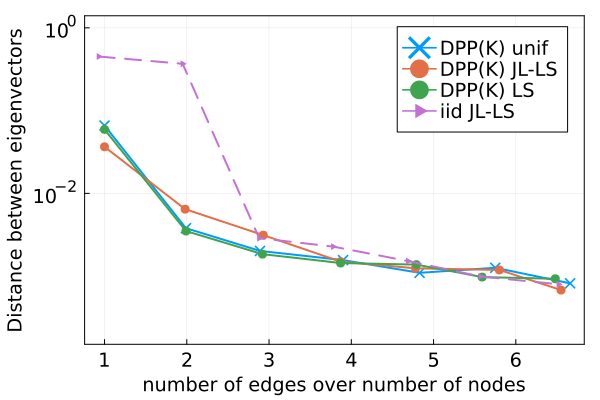

least eigenvalue of sparsifier: 0.009705319822027578


In [7]:
type = "MUN" 

rng = Random.default_rng()

# graph parameters
n = 100
p = 0.9
eta = 0.2

# planted ranking score
planted_score = randperm(rng,n)

# graph model
if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
elseif type=="ERO"
    meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
end

# simulation parameters
n_batch = 7 # maximum number of batches considered
n_rep = 1 # number of runs

# regularization parameter
q = 0

# storing settings
D_params = Dict("n" => n,"p" => p,"eta" => eta,"q" => q,"n_batch" => n_batch,"n_rep" => n_rep)

# print least eigenvalues
# B = magnetic_incidence(meta_g)
# l = eigvals(B' * B)
# println("least eigenvalue: ", l[1:3])


methods = [
    "DPP(K) unif",
    "DPP(K) JL-LS",
    "DPP(K) LS",
    "iid JL-LS",
    # "iid LS",
    #"ST JL-LS",
    # "ST LS",
]

D_results = benchmark_syncrank(meta_g,planted_score, n_batch, n_rep, rng; methods)
# plotting distance between eigenvectors
metric= "err"
y_limits = (1.5*1e-4, 1.4)
legendposition=:topright
plot_comparison_sync(metric,D_results,y_limits;legendposition,methods)
name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")

# saving results
save("figures/"*name*"_data.jld", "D_results", D_results,"D_params", D_params)

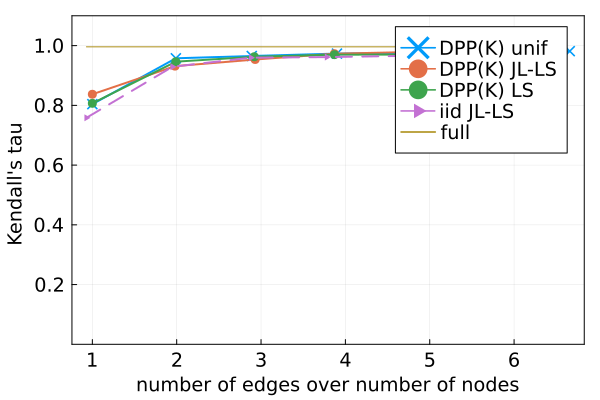

In [8]:
# plotting Kendall's tau between rankings

metric= "tau" 
y_limits = (1.5*1e-4, 1.1)

legendposition=:bottomright
plot_comparison_sync(metric,D_results,y_limits;legendposition,methods)

name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")

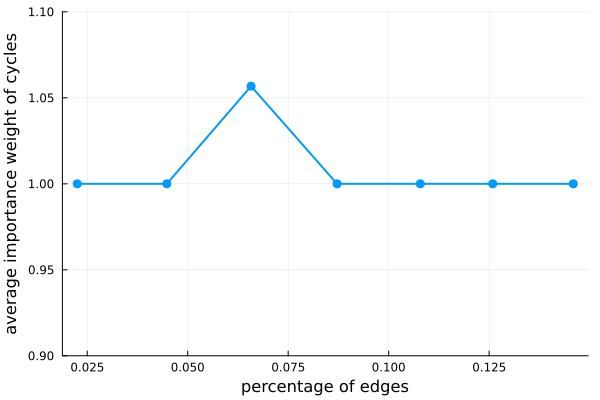

In [9]:
# plotting average importance weight of cycles
metric = "weight"
metric_std = metric * "_std"

method = "DPP(K) LS"
D = D_results[method]
n = D["n"]
m = D["m"]
x = D["pc_edges"]
y = D[metric]
y_er = D[metric_std]
y_limits = (0.9, 1.1)

plt = plot(
    x,
    y;
    yerror=y_er,
    markerstrokecolor=:auto,
    markershape=:circle,
    markersize=5,
    linewidth=2,
    markerstrokewidth=2,
    legend = false
)
xlabel!("percentage of edges")
ylabel!("average importance weight of cycles")

ylims!(y_limits)

display(plt)

name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")

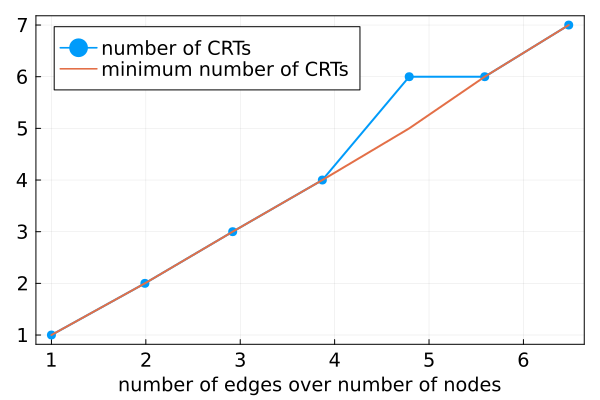

In [10]:
# plotting number of cycle rooted trees wrt number of batches

method = "DPP(K) LS"
legendposition=:topleft
plot_nb_cycles(D_results,method;legendposition)

metric = "number_CRTs"
name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")


 ERO graph model

least eigval of Laplacian= 0.19116482599130946
method: 

DPP(K) unif
least eigenvalue of sparsifier: 0.0015835500320329444
least eigenvalue of sparsifier: 

0.0010075193972744595


least eigenvalue of sparsifier: 0.0005101051225905686
least eigenvalue of sparsifier: 

0.0012955131168149183


least eigenvalue of sparsifier: 9.5676392329448e-5
least eigenvalue of sparsifier: 

0.000473156984825498


least eigenvalue of sparsifier: 0.0016666261202266444
least eigenvalue of sparsifier: 

0.003815730240090855


least eigenvalue of sparsifier: 0.002865337533334113
least eigenvalue of sparsifier: 

0.0007717600479164323


least eigenvalue of sparsifier: 0.110209534863804
least eigenvalue of sparsifier: 

0.10496928937000687


least eigenvalue of sparsifier: 0.058918043442763524
least eigenvalue of sparsifier: 

0.06995668354683171


least eigenvalue of sparsifier: 0.07777965784063451
least eigenvalue of sparsifier: 

0.10432544275897404


least eigenvalue of sparsifier: 0.06807928693440327
least eigenvalue of sparsifier: 

0.08785144428302147


least eigenvalue of sparsifier: 0.09598269492610073
least eigenvalue of sparsifier: 

0.102877868856111


least eigenvalue of sparsifier: 0.09300712503143788
least eigenvalue of sparsifier: 

0.15890230772591213


least eigenvalue of sparsifier: 0.1145367125634957
least eigenvalue of sparsifier: 

0.13217860815927257


least eigenvalue of sparsifier: 0.1254647303700593
least eigenvalue of sparsifier: 

0.13228303449748266


least eigenvalue of sparsifier: 0.11580600540228744
least eigenvalue of sparsifier: 

0.15820244851543916


least eigenvalue of sparsifier: 0.11138288087252673
least eigenvalue of sparsifier: 

0.1181060469220925


least eigenvalue of sparsifier: 0.133875859933332
least eigenvalue of sparsifier: 

0.15611118415109515


least eigenvalue of sparsifier: 0.1647411835921959
least eigenvalue of sparsifier: 

0.12850415478091537


least eigenvalue of sparsifier: 0.08592438581823156
least eigenvalue of sparsifier: 

0.14268423921316226


least eigenvalue of sparsifier: 0.1531864566404792
least eigenvalue of sparsifier: 

0.209664764393164


least eigenvalue of sparsifier: 0.13976754198316116
least eigenvalue of sparsifier: 

0.14569098884952253


least eigenvalue of sparsifier: 0.1560834073554006
least eigenvalue of sparsifier: 

0.16535729471206564


least eigenvalue of sparsifier: 0.18136540973475226
least eigenvalue of sparsifier: 

0.13167435222076057


least eigenvalue of sparsifier: 0.12248295653698343
least eigenvalue of sparsifier: 

0.1633014971607053


least eigenvalue of sparsifier: 0.12717484926078543
least eigenvalue of sparsifier: 

0.14850175024683032


least eigenvalue of sparsifier: 0.15608892768020394
least eigenvalue of sparsifier: 

0.16410388474892343


least eigenvalue of sparsifier: 0.15344923947224937
least eigenvalue of sparsifier: 

0.12138711244878807


least eigenvalue of sparsifier: 0.19602601178496654
least eigenvalue of sparsifier: 

0.16932588108031194


least eigenvalue of sparsifier: 0.15968148578478863
least eigenvalue of sparsifier: 

0.14649286992726146


least eigenvalue of sparsifier: 0.15112008256117748
least eigenvalue of sparsifier: 

0.15872656574049662


least eigenvalue of sparsifier: 0.15643149459588881
least eigenvalue of sparsifier: 

0.17476788282222674


least eigenvalue of sparsifier: 0.16325630672981234
least eigenvalue of sparsifier: 

0.1724574153440692


least eigenvalue of sparsifier: 0.18634794964346685
least eigenvalue of sparsifier: 

0.14774821285999634


least eigenvalue of sparsifier: 0.13914798972688938
least eigenvalue of sparsifier: 

0.1562487443223319


least eigenvalue of sparsifier: 0.1885512297734963
least eigenvalue of sparsifier: 

0.15343460080384788


least eigenvalue of sparsifier: 0.17227221536310258
least eigenvalue of sparsifier: 

0.1488269087113704


method: DPP(K) JL-LS
least eigenvalue of sparsifier: 0.0006199282897346808


least eigenvalue of sparsifier: 0.0014703665305224878
least eigenvalue of sparsifier: 

0.0006607190325695172


least eigenvalue of sparsifier: 0.00036661259041414324
least eigenvalue of sparsifier: 

0.001392656839005807


least eigenvalue of sparsifier: 0.002158847496528525
least eigenvalue of sparsifier: 

0.0006985675012821174


least eigenvalue of sparsifier: 0.0008311181398379763
least eigenvalue of sparsifier: 

0.00015977255624946877


least eigenvalue of sparsifier: 0.002476702615702116
least eigenvalue of sparsifier: 

0.08419644131515679


least eigenvalue of sparsifier: 0.07628740895339509
least eigenvalue of sparsifier: 

0.08879291555855408


least eigenvalue of sparsifier: 0.07813907290393174
least eigenvalue of sparsifier: 

0.0986481145051823


least eigenvalue of sparsifier: 0.06692424525985578
least eigenvalue of sparsifier: 

0.09439314123274611


least eigenvalue of sparsifier: 0.07562105431175026
least eigenvalue of sparsifier: 

0.09326177480135467


least eigenvalue of sparsifier: 0.07398514648821586
least eigenvalue of sparsifier: 

0.10535272342332369


least eigenvalue of sparsifier: 0.10715372842423128
least eigenvalue of sparsifier: 

0.10846994662222151


least eigenvalue of sparsifier: 0.13826216392727408
least eigenvalue of sparsifier: 

0.10893215513164733


least eigenvalue of sparsifier: 0.14970516100144676
least eigenvalue of sparsifier: 

0.10910305847875269


least eigenvalue of sparsifier: 0.1358995430417558
least eigenvalue of sparsifier: 

0.12997045208627528


least eigenvalue of sparsifier: 0.11447236397081079
least eigenvalue of sparsifier: 

0.13041789137319884


least eigenvalue of sparsifier: 0.12526792540421602
least eigenvalue of sparsifier: 

0.09564866305028982


least eigenvalue of sparsifier: 0.1280793958137614
least eigenvalue of sparsifier: 

0.12463396635961552


least eigenvalue of sparsifier: 0.12994502541328132
least eigenvalue of sparsifier: 

0.1393788856019077


least eigenvalue of sparsifier: 0.1316731374538889
least eigenvalue of sparsifier: 

0.15179885984199581


least eigenvalue of sparsifier: 0.10067967300225594
least eigenvalue of sparsifier: 

0.1521862509791203


least eigenvalue of sparsifier: 0.13743248214088127
least eigenvalue of sparsifier: 

0.15345598564964869


least eigenvalue of sparsifier: 0.13230253186760957
least eigenvalue of sparsifier: 

0.15518967312419413


least eigenvalue of sparsifier: 0.15870579013143352
least eigenvalue of sparsifier: 

0.15434936785315673


least eigenvalue of sparsifier: 0.156903414073945
least eigenvalue of sparsifier: 

0.137381237017256


least eigenvalue of sparsifier: 0.15462804075420633
least eigenvalue of sparsifier: 

0.16516643079260285


least eigenvalue of sparsifier: 0.15676639134249906
least eigenvalue of sparsifier: 

0.15158838324886398


least eigenvalue of sparsifier: 0.13884746804825465
least eigenvalue of sparsifier: 

0.16534931465125963


least eigenvalue of sparsifier: 0.14233868064896202
least eigenvalue of sparsifier: 

0.14102580691483135


least eigenvalue of sparsifier: 0.18814848422623537
least eigenvalue of sparsifier: 

0.15169355837232731


least eigenvalue of sparsifier: 0.13320240786948878
least eigenvalue of sparsifier: 

0.12077342341482876


least eigenvalue of sparsifier: 0.16745690312449119
least eigenvalue of sparsifier: 

0.15758525232864223


least eigenvalue of sparsifier: 0.16085785427703203
least eigenvalue of sparsifier: 

0.16181314109910466


least eigenvalue of sparsifier: 0.12872477980061173
least eigenvalue of sparsifier: 

0.15246408923254548


least eigenvalue of sparsifier: 0.16774859907976208
least eigenvalue of sparsifier: 

0.15846966801524554


least eigenvalue of sparsifier: 0.16505398639491145
method: 

DPP(K) LS
least eigenvalue of sparsifier: 0.0005247812127584054
least eigenvalue of sparsifier: 

0.0006190878251103242


least eigenvalue of sparsifier: 0.0018176927369470016
least eigenvalue of sparsifier: 

0.0015709999190267692


least eigenvalue of sparsifier: 0.0018227427611344632
least eigenvalue of sparsifier: 

0.0020021691054496913


least eigenvalue of sparsifier: 0.001332624353127295
least eigenvalue of sparsifier: 

0.0006309182595006086


least eigenvalue of sparsifier: 0.0006530145511540891
least eigenvalue of sparsifier: 

0.0025860411272283033


least eigenvalue of sparsifier: 0.09432201949280039
least eigenvalue of sparsifier: 

0.06289269269008207


least eigenvalue of sparsifier: 0.06650046413964432
least eigenvalue of sparsifier: 

0.0859251930640768


least eigenvalue of sparsifier: 0.11234816049216867
least eigenvalue of sparsifier: 

0.09713639268957126


least eigenvalue of sparsifier: 0.08378228047992725
least eigenvalue of sparsifier: 

0.09297153340025818


least eigenvalue of sparsifier: 0.07152585508347481
least eigenvalue of sparsifier: 

0.09598242848050106


least eigenvalue of sparsifier: 0.12793672446854384
least eigenvalue of sparsifier: 

0.08483186406971473


least eigenvalue of sparsifier: 0.11033849547845137
least eigenvalue of sparsifier: 

0.12559770207355397


least eigenvalue of sparsifier: 0.12151140244620229
least eigenvalue of sparsifier: 

0.14255417816357419


least eigenvalue of sparsifier: 0.10187338216009464
least eigenvalue of sparsifier: 

0.14492760839703467


least eigenvalue of sparsifier: 0.10986603083858629
least eigenvalue of sparsifier: 

0.08424052055872736


least eigenvalue of sparsifier: 0.12834787041298604
least eigenvalue of sparsifier: 

0.13622437871575568


least eigenvalue of sparsifier: 0.10855889289457782
least eigenvalue of sparsifier: 

0.11742370105568528


least eigenvalue of sparsifier: 0.16218400251542045
least eigenvalue of sparsifier: 

0.11270426939591249


least eigenvalue of sparsifier: 0.14472672319307855
least eigenvalue of sparsifier: 

0.11423030531386069


least eigenvalue of sparsifier: 0.11936137918375528
least eigenvalue of sparsifier: 

0.13142745817180507


least eigenvalue of sparsifier: 0.12392030087048289
least eigenvalue of sparsifier: 

0.12223088727569237


least eigenvalue of sparsifier: 0.1208978232442092
least eigenvalue of sparsifier: 

0.1652349285077223


least eigenvalue of sparsifier: 0.14263568792425918
least eigenvalue of sparsifier: 

0.14116038586524982


least eigenvalue of sparsifier: 0.15001723699833663
least eigenvalue of sparsifier: 

0.17801313074986258


least eigenvalue of sparsifier: 0.11415181064100396
least eigenvalue of sparsifier: 

0.13542479297802587


least eigenvalue of sparsifier: 0.1686716602240867
least eigenvalue of sparsifier: 

0.1550881336653665


least eigenvalue of sparsifier: 0.14674236288787873
least eigenvalue of sparsifier: 

0.16275356695907373


least eigenvalue of sparsifier: 0.14634916772273737
least eigenvalue of sparsifier: 

0.15164267396268755


least eigenvalue of sparsifier: 0.17162695505243053
least eigenvalue of sparsifier: 

0.13472784588418008


least eigenvalue of sparsifier: 0.1449204525010932
least eigenvalue of sparsifier: 

0.16727673540319707


least eigenvalue of sparsifier: 0.16153919003942668
least eigenvalue of sparsifier: 

0.16499762134993118


least eigenvalue of sparsifier: 0.16397938436659654
least eigenvalue of sparsifier: 

0.13275406331430972


least eigenvalue of sparsifier: 0.14584872324012638
least eigenvalue of sparsifier: 

0.16059376131302533


least eigenvalue of sparsifier: 0.14298913285718268
least eigenvalue of sparsifier: 

0.1373663971082729


least eigenvalue of sparsifier: 0.16251428496844378
least eigenvalue of sparsifier: 

0.18583531583226884


method: iid JL-LS
least eigenvalue of sparsifier: 1.5418324179152834e-11


least eigenvalue of sparsifier: 1.987479654002077e-12
least eigenvalue of sparsifier: 

1.1238811589463972e-13


least eigenvalue of sparsifier: 7.995759814220463e-9
least eigenvalue of sparsifier: 

8.096568503543418e-12


least eigenvalue of sparsifier: 6.596859156634949e-13
least eigenvalue of sparsifier: 

3.2321233943105788e-12


least eigenvalue of sparsifier: 3.233364831355462e-9
least eigenvalue of sparsifier: 

4.165866757434928e-11


least eigenvalue of sparsifier: 4.513525026339422e-6
least eigenvalue of sparsifier: 

3.3679482102096328e-12


least eigenvalue of sparsifier: 3.351852924488385e-14
least eigenvalue of sparsifier: 

7.73052567953016e-11


least eigenvalue of sparsifier: 2.294525571381359e-12
least eigenvalue of sparsifier: 

1.619739830580091e-11


least eigenvalue of sparsifier: 0.0505607075322491
least eigenvalue of sparsifier: 

5.04888659633032e-14


least eigenvalue of sparsifier: 1.5396480973082916e-12
least eigenvalue of sparsifier: 

2.5272394010615525e-11


least eigenvalue of sparsifier: 0.07746165699420696
least eigenvalue of sparsifier: 

0.10514145625394178


least eigenvalue of sparsifier: 0.07780672273587863
least eigenvalue of sparsifier: 

3.920490038386308e-12


least eigenvalue of sparsifier: 0.11065621157481743
least eigenvalue of sparsifier: 

2.8205780801835186e-10


least eigenvalue of sparsifier: 0.10365257727898691
least eigenvalue of sparsifier: 

0.09707240071858214


least eigenvalue of sparsifier: 6.569087787508241e-14
least eigenvalue of sparsifier: 

8.233319048548232e-13


least eigenvalue of sparsifier: 0.09457879564403757
least eigenvalue of sparsifier: 

0.13805152032236234


least eigenvalue of sparsifier: 0.09765698420797682
least eigenvalue of sparsifier: 

0.12949034754088867


least eigenvalue of sparsifier: 0.11518544505546582
least eigenvalue of sparsifier: 

0.1113484833715795


least eigenvalue of sparsifier: 0.15239547508269624
least eigenvalue of sparsifier: 

0.09566637272144154


least eigenvalue of sparsifier: 0.11096885336991874
least eigenvalue of sparsifier: 

0.11251629992978764


least eigenvalue of sparsifier: 0.10098793263998038
least eigenvalue of sparsifier: 

0.12339593754986528


least eigenvalue of sparsifier: 0.1434701114586846
least eigenvalue of sparsifier: 

0.15410888685256524


least eigenvalue of sparsifier: 0.13516299066158716
least eigenvalue of sparsifier: 

0.13704194754216026


least eigenvalue of sparsifier: 0.15380056938413583
least eigenvalue of sparsifier: 

0.15834885830466794


least eigenvalue of sparsifier: 0.15769927035055964
least eigenvalue of sparsifier: 

0.1464541668745027


least eigenvalue of sparsifier: 0.1263932069846673
least eigenvalue of sparsifier: 

0.14839064206556607


least eigenvalue of sparsifier: 0.13987415333750447
least eigenvalue of sparsifier: 

0.1527046555755301


least eigenvalue of sparsifier: 0.13936398680069412
least eigenvalue of sparsifier: 

0.16903924951630245


least eigenvalue of sparsifier: 0.15663063858862608
least eigenvalue of sparsifier: 

0.13049944968514332


least eigenvalue of sparsifier: 0.164647645334681
least eigenvalue of sparsifier: 

0.15595836971715998


least eigenvalue of sparsifier: 0.15183878338783616
least eigenvalue of sparsifier: 

0.1529284335178646


least eigenvalue of sparsifier: 0.16234268274685426
least eigenvalue of sparsifier: 

0.17062829158889853


least eigenvalue of sparsifier: 0.1756917630607448
least eigenvalue of sparsifier: 

0.15445494466822074


least eigenvalue of sparsifier: 0.15368691716470512
least eigenvalue of sparsifier: 

0.16435657372134846


least eigenvalue of sparsifier: 0.1784730038356454
least eigenvalue of sparsifier: 

0.05890710384792705


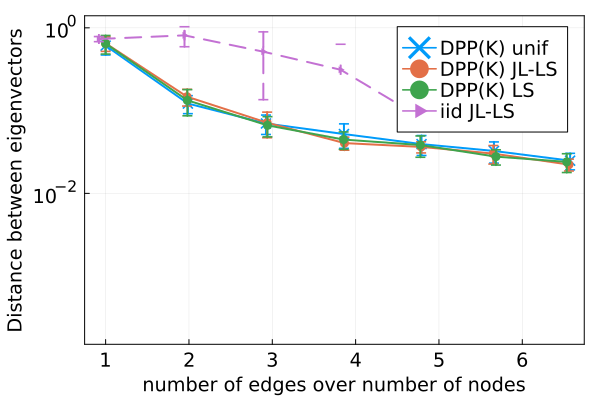

least eigenvalue of sparsifier: 0.13990929340513897


GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


In [11]:
type = "ERO" 

rng = Random.default_rng()

# graph parameters
n = 100
p = 0.9
eta = 0.2

# planted ranking score
planted_score = randperm(rng,n)

# graph model
if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta;planted_score)
elseif type=="ERO"
    meta_g = gen_graph_ero(rng, n, p, eta;planted_score)
end

# simulation parameters
n_batch = 7 # maximum number of batches considered
n_rep = 10 # number of runs

# regularization parameter
q = 0

# storing settings
D_params = Dict("n" => n,"p" => p,"eta" => eta,"q" => q,"n_batch" => n_batch,"n_rep" => n_rep)

# print least eigenvalues
# B = magnetic_incidence(meta_g)
# l = eigvals(B' * B)
# println("least eigenvalue: ", l[1:3])

D_results = benchmark_syncrank(meta_g,planted_score, n_batch, n_rep, rng;methods)

# plotting distance between eigenvectors
metric= "err"
y_limits = (1.5*1e-4, 1.4)
legendposition=:bottomright
plot_comparison_sync(metric,D_results,y_limits;legendposition,methods)
name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")

# saving results
save("figures/"*name*"_data.jld", "D_results", D_results,"D_params", D_params)

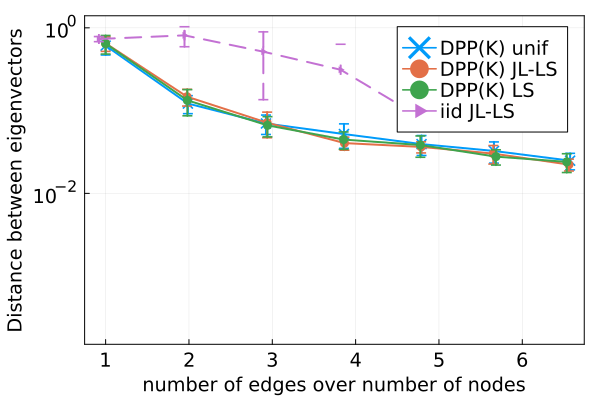

GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE
GKS: Number of points is invalid in routine POLYLINE


In [12]:
# plotting distance between eigenvectors
metric= "err"
y_limits = (1.5*1e-4, 1.4)
legendposition=:bottomright
plot_comparison_sync(metric,D_results,y_limits;legendposition,methods)
name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")

# saving results
save("figures/"*name*"_data.jld", "D_results", D_results,"D_params", D_params)

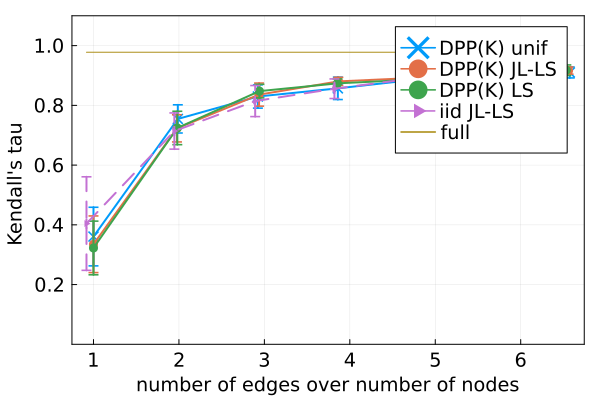

In [13]:
# plotting Kendall's tau between rankings

metric= "tau" 
y_limits = (1.5*1e-4, 1.1)

legendposition=:bottomright
plot_comparison_sync(metric,D_results,y_limits;legendposition, methods)

name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")

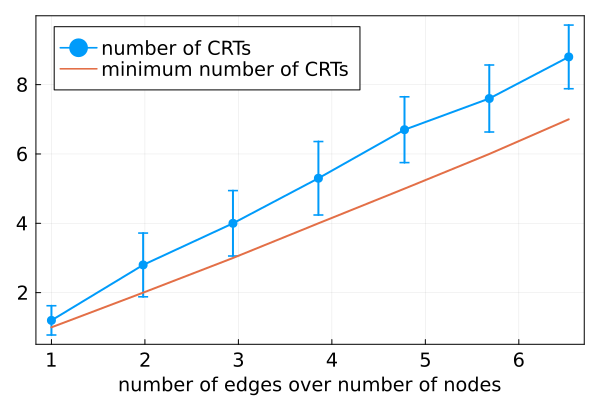

In [14]:
# plotting number of cycle rooted trees wrt number of batches

method = "DPP(K) LS"
legendposition=:topleft
plot_nb_cycles(D_results,method;legendposition)

metric = "number_CRTs"
name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")

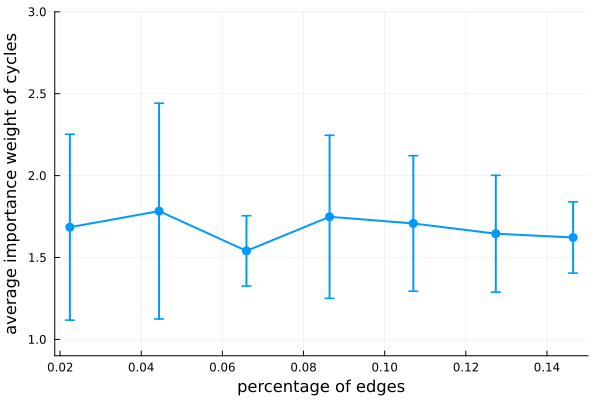

In [15]:
# plotting average importance weight of cycles
metric = "weight"
metric_std = metric * "_std"

method = "DPP(K) LS"
D = D_results[method]
x = D["pc_edges"]
y = D[metric]
y_er = D[metric_std]
y_limits = (0.9, 3)

plt = plot(
    x,
    y;
    yerror=y_er,
    markerstrokecolor=:auto,
    markershape=:circle,
    markersize=5,
    linewidth=2,
    markerstrokewidth=2,
    legend = false
)
xlabel!("percentage of edges")
ylabel!("average importance weight of cycles")

ylims!(y_limits)

display(plt)

name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")

SBM MUN


connected graph generated with m/n = 19.9225
least eigval of Laplacian= 0.10553638443330396


method: DPP(K) unif
least eigenvalue of sparsifier: 7.531779473408934e-5


least eigenvalue of sparsifier: 0.05946366921228856
least eigenvalue of sparsifier: 

0.06524377324649006


least eigenvalue of sparsifier: 0.07035861764878888
least eigenvalue of sparsifier: 

0.08324453161372339


least eigenvalue of sparsifier: 0.08738516686355784
least eigenvalue of sparsifier: 

0.08644542813452744


method: DPP(K) JL-LS
least eigenvalue of sparsifier: 0.000127351601332216


least eigenvalue of sparsifier: 0.05083896611270898
least eigenvalue of sparsifier: 

0.07383620092151055


least eigenvalue of sparsifier: 0.08655649347597813
least eigenvalue of sparsifier: 

0.08709408329068219


least eigenvalue of sparsifier: 0.07735792937557329
least eigenvalue of sparsifier: 

0.0859335696827227


method: iid JL-LS
least eigenvalue of sparsifier: 6.456165525881486e-13


least eigenvalue of sparsifier: 1.925853700526416e-13
least eigenvalue of sparsifier: 

8.739681103669428e-13


least eigenvalue of sparsifier: 0.0736165484837614
least eigenvalue of sparsifier: 

0.08139675759138383


least eigenvalue of sparsifier: 0.08257468245571381
least eigenvalue of sparsifier: 

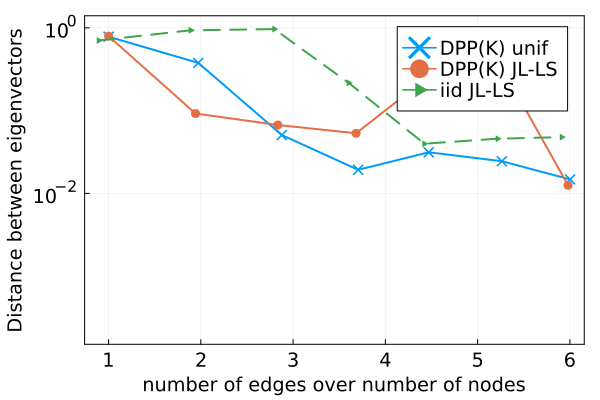

0.0857125095144369


In [44]:
rng = Random.default_rng()

# graph parameters
n = 400
p_in = 0.2
p_out = 0.001
η = 0.1
#noise = 0.3

# planted ranking score
planted_score = randperm(rng,n)


meta_g = MetaGraph(n)
ic = false
while !ic
    if type=="MUN"
        meta_g = ero_mun_sbm(rng,n,p_in,p_out,η,noise;planted_score)
    elseif type=="ERO"
        meta_g = ero_mun_sbm(rng,n,p_in,p_out,η,noise;planted_score)
    end
    ic = is_connected(meta_g)
end
println("connected graph generated with m/n = ", ne(meta_g) / nv(meta_g))



# simulation parameters
n_batch = 7 # maximum number of batches considered
n_rep = 1 # number of runs

# regularization parameter
q = 0

# # storing settings
# D_params = Dict("n" => n,"p" => p,"eta" => eta,"q" => q,"n_batch" => n_batch,"n_rep" => n_rep)


methods = [
    "DPP(K) unif",
    "DPP(K) JL-LS",
    #"DPP(K) LS",
    "iid JL-LS",
    # "iid LS",
    #"ST JL-LS",
    # "ST LS",
]

D_results = benchmark_syncrank(meta_g,planted_score, n_batch, n_rep, rng; methods)
# plotting distance between eigenvectors
metric= "err"
y_limits = (1.5*1e-4, 1.4)
legendposition=:topright
plot_comparison_sync(metric,D_results,y_limits;legendposition,methods)
name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")

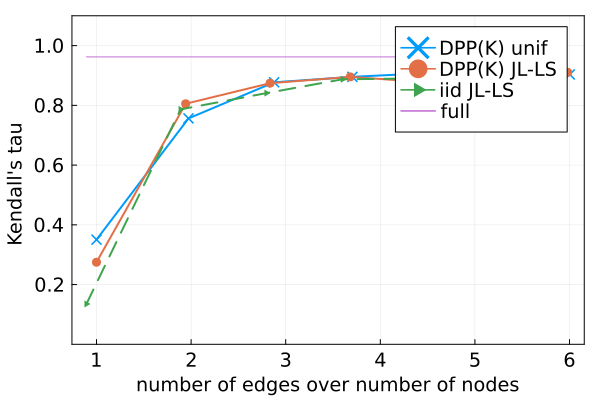

In [45]:
# plotting Kendall's tau between rankings

metric= "tau" 
y_limits = (1.5*1e-4, 1.1)

legendposition=:bottomright
plot_comparison_sync(metric,D_results,y_limits;legendposition,methods)

name = "syncrank_"*metric*"_"*type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"q"*string(q)

# saving plot
savefig("figures/"*name*".pdf")